# Introdução

O presente trabalho é uma releitura do trabalho apresentado em Regressão Linear, o qual pode ser acessado clicando [aqui](https://github.com/VitorBSP/gdp-statesBR). 

Assim buscaremos entender se um modelo de Regressão Linear com todas as boas características que um modelo estatísticos exige, homocedasticidade dos erros, resíduos com média zero, não-autocorrelação, modelo corretamente especificado, sem multicolinearidade e com normalidade dos erros. Consegue competir com o estado da arte dos modelos de aprendizado de máquina para dados tabulares como Random Forest, XGBosst e LightGBM.

Para isso selecionamos um dataset onde o objetivo é predizer o produto interno bruto per capita (PIB) dos 26 estados do Brasil nos anos de 2019, 2020 e 2021, assim cada ano será utilizado como dados de treino, teste e validação, respectivamente, os dados foram extraidos de planinhas disponíveis no site do Instituto Brasileiro de Geografia e Estatística (IBGE Cidades) para isso utiliza-se  como variáveis explicativas (covariáveis):

**Pobreza**: Que fornece a taxa de extrema pobreza no ano;

**Densidade Demográfica**: Informa a densidade demográfica de cada estado no ano de;  

**Área** : Refere-se a área em km de cada estado no ano de; 

**Índice de Desenvolvimento Humano  Educacional** (IDHe) : Refere-se ao IDH educacional no de ano de 2017, a escolha das covariáveis foram para conter três eixos:

*População e Geográfia do Estado*: Área e Densidade Demográfica;

*Condição de Vida*: Pobreza;

*Educação* : IDHe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import preprocessing
from utils.functions import *
le = preprocessing.LabelEncoder()

In [2]:
base = pd.read_csv("./data/data_modelagem.csv")
base = base.drop(columns=['State', 'Unnamed: 0'])
base = base.rename(columns={'%_de_extremamente_pobres_':"%_ext_pob",'idhm_ajustado_à_desigualdade_':'idhm_desigualdade'})

A Tabela (Descritiva) apresenta os resultados descritivos das variáveis em estudo. Nela a variável renda per capita apresentou mínimo de 264, média de 702, e máximo de 1498, levando em conta que o quantil 75% apresenta 847 de renda per capita, é uma diferença grande do máximo para esse valor. Para a porcentagem de extrema pobraza, temos média de 6.85%. Considerando as variáveis IDHM para Educação, Longevidade e Desigualdade, temos médias de 0.7336, 0.8359 e 0.5870, respectivamente. Por fim, a Área apresenta média de 315216, aproximadamente. Sem a existência de qualquer dado nulo.

In [3]:
base.iloc[0:27,:].describe()

,renda_per_capita_,%_ext_pob,população_total_,idhm_educação_,idhm_longevidade_,idhm_desigualdade,Area
count,27.000000,27.000000,2.700000e+01,27.000000,27.000000,27.000000,2.700000e+01
mean,702.846667,6.851852,7.759128e+06,0.733630,0.835889,0.587037,3.152156e+05
std,264.649058,4.578216,9.256985e+06,0.053191,0.043178,0.064692,3.751019e+05
min,366.240000,1.300000,5.397410e+05,0.639000,0.773000,0.500000,5.760783e+03
25%,516.330000,2.550000,2.861026e+06,0.698000,0.799000,0.535000,7.609908e+04
50%,598.770000,6.720000,3.996784e+06,0.735000,0.828000,0.566000,2.242738e+05
75%,847.060000,10.570000,9.314394e+06,0.770000,0.874500,0.638500,3.348839e+05
max,1498.740000,17.310000,4.591267e+07,0.849000,0.916000,0.705000,1.559168e+06


Analizando a Figura (Boxplot), as regiões Norte e Nordeste apresentam as menores rendas per capita. Na região nordeste vemos um outlier, sendo o estado de Maranhão. Para as regiões Centro-Oeste, Sudeste e Sul, a renda per capita são mais elevedas, com a região Centro-Oeste apresentando um outlier, sendo o Distrito Federal. 

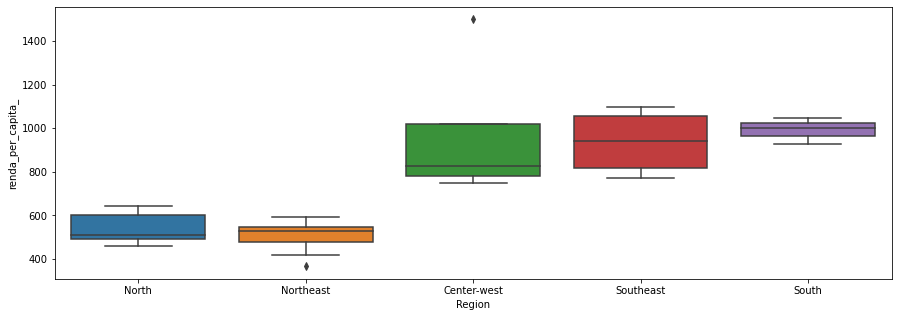

In [4]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='Region', y='renda_per_capita_', data=base.iloc[0:27, :]);

Pela Figura (Dispersão 1) são apresentados diagramas de dispersão para as variáveis porcentagem de extrema pobreza e população total com a variável resposta renda per capita, separadas pelas regiões. Então, percebe-se que as maiores porcentagens de extrema pobreza estão na região nordeste, aumentando conforme a diminuição da renda percapita. Já os menores índices de pobreza estão nas regiões Centro-Oeste, Sudeste e Sul, com a região Centro-Oeste apresentando a maior renda per capita, no Distrito Federal. 

Olhando para a população total, no Distrito Federal mesmo apresentando uma população não tão expressiva, ainda contém a maior renda per capita. As regiões do Sudeste apresentaram as maiores quantidades de pupulação. Nordeste e Norte com as menores pupulações e renda per capita, como visto acima.

<Figure size 1080x360 with 0 Axes>

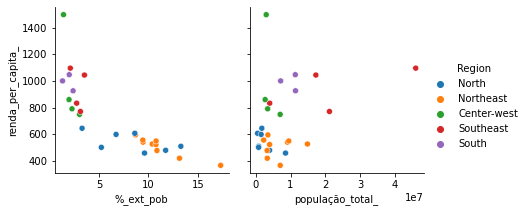

In [5]:
plt.figure(figsize=(15, 5))
sns.PairGrid(data=base.iloc[0:27,:],y_vars=['renda_per_capita_'],x_vars=["%_ext_pob","população_total_"]
,hue='Region',height=3).map(sns.scatterplot).add_legend()


Observando a Figura (Dispersão 2), no qual são apresentados diagramas de dispersão para as variáveis IDHM Educação e IDHM Longevidade com a variável resposta renda per capita, separadas pelas regiões. Nestas duas variáveis o comportamento é muito similar, com o Distrito Federal apresentando índices bem elevados dos IDHM. Junto com algumas regiões do Sudeste e Sul.

<Figure size 1080x360 with 0 Axes>

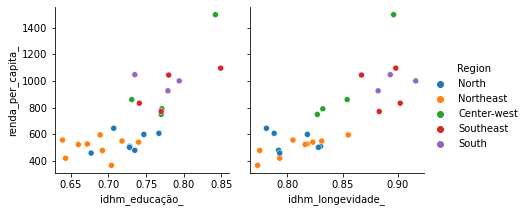

In [6]:
plt.figure(figsize=(15, 5))
sns.PairGrid(data=base.iloc[0:27,:],y_vars=['renda_per_capita_'],x_vars=['idhm_educação_','idhm_longevidade_']
,hue='Region',height=3).map(sns.scatterplot).add_legend();

Note pelo seguinte gráfico (Barra 1) que os estados da região Norte estão bem próximos da média do PIB per capita por estado (702.84666), SP e DF estão bem acima e os estados da região nordeste estão bem abaixo.


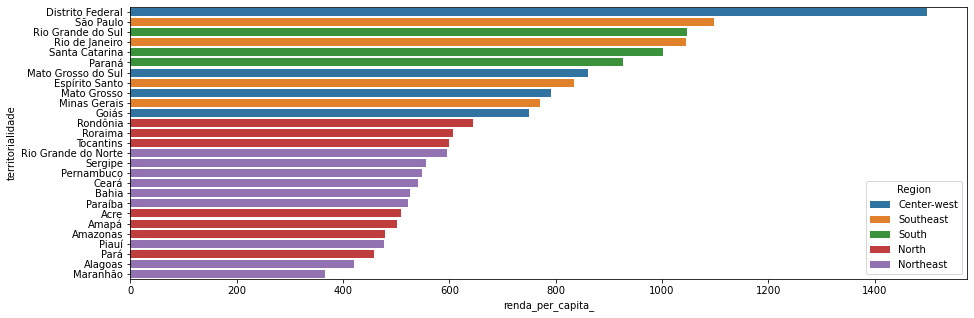

In [7]:
plt.figure(figsize=(15, 5))
sns.barplot(data=base.iloc[0:27,:].sort_values('renda_per_capita_', ascending=False), y='territorialidade', x = 'renda_per_capita_', hue = 'Region', dodge=False);

In [8]:
dummies = pd.get_dummies(base['Region'])
base[dummies.columns] = dummies

In [9]:
base = base.drop(columns=['Region'])

In [10]:
treino = base.iloc[0:27, :].drop(columns=['territorialidade'])
teste = base.iloc[27:54, :].drop(columns=['territorialidade'])
val = base.iloc[54:81, :].drop(columns=['territorialidade'])

In [11]:
y_treino = treino['renda_per_capita_']
y_teste = teste['renda_per_capita_']
y_val = val['renda_per_capita_']
treino = treino.drop(columns=['renda_per_capita_'])
teste = teste.drop(columns=['renda_per_capita_'])
val = val.drop(columns=['renda_per_capita_'])

# Feature Selection

Para selecionarmos as variáveis que estarão presentes na modelagem , selecionado apenas as variáveis com valor preditivo,utilizaremos duas técnicas de feature selecion:

    * SelectKBest: que demonstra quais das covariáveis estão mais correlacionadas com a variável resposta.
    * Correlação entre as covariáveis, para que evite-se multicolineariedade e covariáveis que expliquem a mesma variação.

In [12]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
selector = SelectKBest(score_func=f_regression, k=treino.shape[1])
selector.fit(treino, y_treino)
features = pd.DataFrame({'variables' : treino.columns, 'pvalues' : selector.pvalues_, })
features.sort_values(['pvalues'], ascending=False )

,variables,pvalues
5,Area,2.240339e-01
7,North,6.169539e-02
1,população_total_,5.995131e-02
10,Southeast,5.365048e-02
9,South,4.241665e-02
6,Center-west,2.270295e-02
8,Northeast,3.988380e-03
2,idhm_educação_,1.496472e-06
0,%_ext_pob,2.658631e-07
3,idhm_longevidade_,2.123200e-07


Na Figura (correlação) são apresentados as correlações entre as variáveis quantitativas em estudo. Observando a variável de extrema pobreza, nota-se que esta variável apresenta correlações fortes com praticamente todas as outras variáveis. Mesmo apresentando correlação forte com a variável resposta renda per capita, ela causará problemas de autocorrelação entre os dados. Portando, não usaremos na modelagem. Já considerando as outras variáveis explicativas, nenhuma delas apresentam correlações muito elevadas entre elas. Olhando para a variável resposta, apenas a população total e a área não apresentam correlações fortes com ela.

Percebe-se também que a porcentagem de extrema pobreza possui correlação negativa com a variável resposta, ou seja, diminui a porcentagem de extrema pobreza conforme o aumento da renda per capita do local. Já para as demais variáveis explicativas, com exceção da área, todas apresentam correlação positiva, conforme aumento da renda per capita, tbm há um aumento em seus índices.

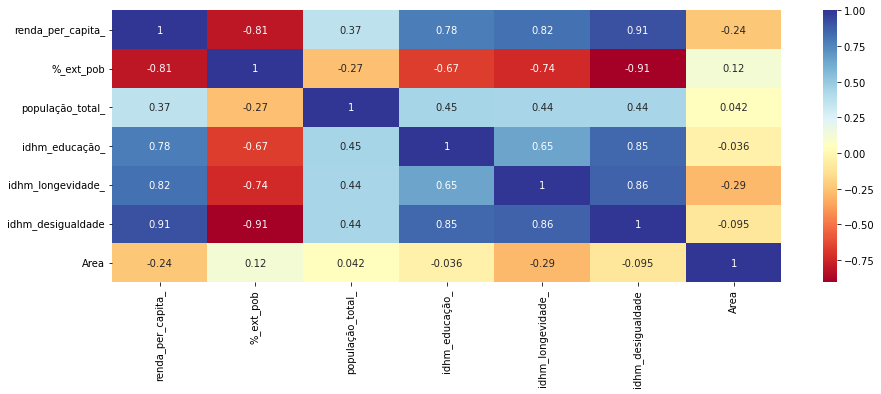

In [13]:
plt.figure(figsize=(15, 5))
sns.heatmap(base.iloc[0:27, 0:8].corr(), annot=True,cmap='RdYlBu');

In [14]:
treino = treino.drop(columns=['%_ext_pob'])
teste = teste.drop(columns=['%_ext_pob'])
val = val.drop(columns=['%_ext_pob'])

# Modelagem


Vamos aqui realizar a análise preditiva, onde queremos obter o modelo com maior poder preditivo para avaliar a renda per capita, assim utilizaremos os dados de 2019 como treino, os de 2020 como teste para o ajuste dos hiperparâmetros e os dados de 2021 para a validação final das métricas. Visto que temos uma base de dados com poucas observações utilizaremos 8 modelos para ver o qual se saí melhor na predição: Regressão Linear, ElasticNet, Lasso, Ridge, Árvores de Decisão, Random Forest, LightGBM e XGBoost.

Para o ajuste dos hiperparâmetros utilizaremos a busca aleatória e a busca bayesiana.


In [15]:
def search_space(model):
    model = model.lower()
    space = {}
    if model == 'dt':
        space = {
            'min_samples_leaf': hp.randint('min_samples_leaf', 1,50),
            'max_depth': hp.randint('max_depth', 1,25),
            'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
            'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 1)
            }
    elif model == 'lasso':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 10),
            'warm_start' : hp.choice('warm_start', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000))
            }
    elif model == 'ridge':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 500),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            'solver' : hp.choice('solver', ['svd', 'sag', 'saga', 'lbfgs', 'auto']),
            }
    elif model == 'linear':
         space = {
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            }
    elif model == 'elastic':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 100),
            'l1_ratio' : hp.uniform('l1_ratio', 0, 1),
            'warm_start' : hp.choice('warm_start', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            }
    elif model == 'rf':
        space = {
                'min_samples_leaf': hp.randint('min_samples_leaf', 1,50),
                'max_depth': hp.randint('max_depth', 1,20),
                'n_estimators': hp.randint('n_estimators', 50,1000),
                'max_leaf_nodes' : hp.randint('max_leaf_nodes', 2,100),
                'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.3)
            }
    elif model == 'lgbm':
        space = {
            'num_leaves':  hp.randint('num_leaves', 1,50),
            'max_depth': hp.randint('max_depth', 1,20),
            'feature_fraction':  hp.uniform('feature_fraction', 0.2, 0.5),
            'subsample':  hp.uniform('subsample', 0.2, 1),
            'bagging_fraction':  hp.uniform('bagging_fraction', 0.5, 0.9),    
            'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
            'lambda_l1':  hp.uniform('lambda_l1', 0.0001, 1),
            'lambda_l2':  hp.uniform('lambda_l2', 0.0001, 1),
            'min_child_samples': hp.randint('min_child_samples', 1,50),
            'n_estimators': hp.randint('n_estimators', 50,1000),
            'colsample_bytree':  hp.uniform('colsample_bytree', 0.1, 1)  
            }
    elif model == 'xgb':
        space={
                'max_depth': hp.choice('max_depth', range(1,20)),
                'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
                'gamma': hp.uniform ('gamma', 1,9),
                'min_child_samples': hp.choice('min_child_samples', range(1,50)),
                'subsample':  hp.uniform('subsample', 0.2, 1),
                'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
                'reg_lambda' : hp.uniform('reg_lambda', 0,1),
                'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
                'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
                'n_estimators': hp.choice('n_estimators', range(50,1000)),
                'parallel_tree': hp.uniform ('parallel_tree', 1,10),
            }
    space['model'] = model
    return space

In [16]:
models = {
            'dt' : DecisionTreeRegressor,
            'rf' : RandomForestRegressor,
            'xgb' : XGBRegressor,
            'lgbm' : LGBMRegressor ,
            'lasso' : Lasso,
            'elastic' : ElasticNet,
            'ridge' : Ridge,
            'linear' : LinearRegression
        }

In [17]:
def get_acc_status(clf,X_,y):
    acc = cross_val_score(clf, X_, y, cv=5, scoring="neg_root_mean_squared_error").mean()
    display(clear=True)
    return {'loss': -acc, 'status': STATUS_OK}

def obj_fnc(params):
    print(type(params.get('model')), '---')
    model = params.get('model').lower()
    del params['model']
    clf = models[model](**params)
    display(clear=True)
    return(get_acc_status(clf,treino,y_treino))

In [37]:
best_params = {}
hypopt_trials = {}

for model in models:
    hypopt_trials[model] = Trials()
    best_params[model] = fmin(obj_fnc, search_space(model), algo=tpe.suggest,
    max_evals=50, trials= hypopt_trials[model])
    print(best_params[model])
    print(hypopt_trials[model].best_trial['result']['loss'])

100%|██████████| 50/50 [00:02<00:00, 24.38trial/s, best loss: 142.03972847641143]
{'fit_intercept': 0}
142.03972847641143


In [38]:
for model in best_params:
    if model == 'rf':
        crit = {0: 'gini', 1:  'entropy', 2: 'log_loss'}
        feat = {0: 'sqrt', 1: 'log2', 2: None}

        trainedforest = RandomForestRegressor(
                                            min_samples_leaf = best_params[model]['min_samples_leaf'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            min_impurity_decrease = best_params[model]['min_impurity_decrease'], 
                                            max_leaf_nodes = best_params[model]['max_leaf_nodes'], 
                                            n_estimators = best_params[model]['n_estimators']
                                            ).fit(treino, y_treino)

    elif model == 'xgb':
         trainedxgb = XGBRegressor(learning_rate = best_params[model]['learning_rate'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            gamma = best_params[model]['gamma'],
                                            min_child_samples = best_params[model]['min_child_samples'],
                                            subsample = best_params[model]['subsample'], 
                                            reg_alpha = best_params[model]['reg_alpha'],
                                            reg_lambda = best_params[model]['reg_lambda'],
                                            colsample_bytree = best_params[model]['colsample_bytree'], 
                                            min_child_weight = best_params[model]['min_child_weight'], 
                                            parallel_tree = best_params[model]['parallel_tree'], 
                                            n_estimators = best_params[model]['n_estimators']
                                            ).fit(treino, y_treino)
    elif model == 'lgbm':
         trainedlgbm = LGBMRegressor(learning_rate = best_params[model]['learning_rate'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            num_leaves = best_params[model]['num_leaves'],
                                            subsample = best_params[model]['subsample'], 
                                            colsample_bytree = best_params[model]['colsample_bytree'], 
                                            feature_fraction = best_params[model]['feature_fraction'], 
                                            bagging_fraction = best_params[model]['bagging_fraction'], 
                                            n_estimators = best_params[model]['n_estimators'],
                                            lambda_l1 = best_params[model]['lambda_l1'],
                                            lambda_l2 = best_params[model]['lambda_l2'],
                                            min_child_samples = best_params[model]['min_child_samples']
                                            ).fit(treino, y_treino)

    elif model == 'dt':
        feat = {0: 'sqrt', 1: 'log2', 2: None}
        trainedtree = DecisionTreeRegressor(
                                            max_depth = best_params[model]['max_depth'], 
                                            max_features = feat[best_params[model]['max_features']], 
                                            min_samples_leaf = best_params[model]['min_samples_leaf'], 
                                            min_impurity_decrease = best_params[model]['min_impurity_decrease']).fit(treino, y_treino)
    elif model == 'lasso':
        booleano = {0 : True, 1 : False}

        trainedlasso = Lasso(
                                            alpha=best_params[model]['alpha'],
                                            warm_start = booleano[best_params[model]['warm_start']],
                                            tol = best_params[model]['tol'],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'ridge':
        booleano = {0 : True, 1 : False}
        solver = {0: 'svd', 1: 'sag', 2: 'saga', 3 : 'lbfgs', 4 : 'auto'}
        trainedridge = Ridge(
                                            alpha=best_params[model]['alpha'],
                                            tol = best_params[model]['tol'],
                                            solver = solver[best_params[model]['solver']],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'elastic':
        booleano = {0 : True, 1 : False}
        trainedelastic = ElasticNet(
                                            l1_ratio=best_params[model]['l1_ratio'],
                                            alpha=best_params[model]['alpha'],
                                            warm_start = booleano[best_params[model]['warm_start']],
                                            tol = best_params[model]['tol'],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'linear':
        booleano = {0 : True, 1 : False}
        trainedlinear = LinearRegression(fit_intercept = booleano[best_params[model]['fit_intercept']]).fit(treino, y_treino)


[14:42:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_child_samples", "parallel_tree" } are not used.

[LightGBM] [Warning] feature_fraction is set=0.27288111190398023, colsample_bytree=0.1455520116143903 will be ignored. Current value: feature_fraction=0.27288111190398023
[LightGBM] [Warning] lambda_l1 is set=0.9175903324681571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9175903324681571
[LightGBM] [Warning] bagging_fraction is set=0.5563039228119312, subsample=0.47098685150997244 will be ignored. Current value: bagging_fraction=0.5563039228119312
[LightGBM] [Warning] lambda_l2 is set=0.7002741458038777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7002741458038777


# Conclusão

Para a avaliação da qualidade dos modelos que ajustamos (considerando os hiperparâmetros) utilizaremos as métricas de erro mais usuais: R^2 (R quadrado), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) e Mean Absolute Percentage Error (MAPE).

In [39]:
def regression_metrics(model):
    y_pred = model.predict(val)
    metrics = [r2_score(y_val, y_pred), mean_absolute_error(y_val,y_pred), np.sqrt(mean_squared_error(y_val, y_pred)),mean_absolute_percentage_error(y_val, y_pred)]
    return metrics

In [40]:
trained_models = {
            'dt' : trainedtree,
            'rf' : trainedforest,
            'xgb' : trainedxgb,
            'lgbm' : trainedlgbm ,
            'lasso' : trainedlasso,
            'elastic' : trainedelastic,
            'ridge' : trainedridge,
            'linear' : trainedlinear
        }

In [41]:
metrics = pd.DataFrame()
metrics['metricas'] = ['R^2', 'MAE', 'RMSE', 'MAPE']
for model in trained_models:
    metrics[model] = regression_metrics(trained_models[model])

Conforme podemos ver pela Tabela abaixo (Tabela 1), temos que o LightGBM (um dos maiores concorrentes do XGBoost para dados tabulares), se sobressaí a todos os modelos em todas as 4 métricas, com bons valores para todas elas. Destaca-se que a Regressão Lasso superou o XGBoost no R^2, MAE e RMSE (com considerável vantagem), indicando erros com menor magnitude, assim como a Regressão Linear ficando apenas atráss desses 3 modelos de maneira geral.

Percebe-se também as árvores de decisão se aproximando ou até superando a Random Forest em algumas métricas, e os piores modelos sendo a ElasticNet e a Regressão Ridge, com performance geral extremamente abaixo dos outros modelos.

Assim caso fosse necessário colocar o modelo em produção selecionaríamos o modelo com algoritmo LightGBM para melhor capacidade preditiva ou o modelo com Regressão Lasso (até mesmo o Modelo com Regressão Linear) caso a capacidade computacional seja um impeditivo.

In [42]:
metrics

,metricas,dt,rf,xgb,lgbm,lasso,elastic,ridge,linear
0,R^2,0.491235,0.801810,0.796115,0.922883,0.826164,0.681905,0.154842,0.745867
1,MAE,119.061185,69.604984,68.664799,47.619828,71.266652,103.143298,167.534531,80.978206
2,RMSE,160.591805,100.231830,101.661839,62.523070,93.871754,126.982368,206.982633,113.499998
3,MAPE,0.173661,0.101816,0.101312,0.074964,0.112411,0.173510,0.304072,0.121980


In [44]:
metrics.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>metricas</th>\n      <th>dt</th>\n      <th>rf</th>\n      <th>xgb</th>\n      <th>lgbm</th>\n      <th>lasso</th>\n      <th>elastic</th>\n      <th>ridge</th>\n      <th>linear</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>R^2</td>\n      <td>0.491235</td>\n      <td>0.801810</td>\n      <td>0.796115</td>\n      <td>0.922883</td>\n      <td>0.826164</td>\n      <td>0.681905</td>\n      <td>0.154842</td>\n      <td>0.745867</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>MAE</td>\n      <td>119.061185</td>\n      <td>69.604984</td>\n      <td>68.664799</td>\n      <td>47.619828</td>\n      <td>71.266652</td>\n      <td>103.143298</td>\n      <td>167.534531</td>\n      <td>80.978206</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>RMSE</td>\n      <td>160.591805</td>\n      <td>100.231830</td>\n      <td>101.661839</td>\n      <t